# Hands-on ML Final Project

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

## State of art

### Introduction

Medical images play a crucial role in the field of healthcare, providing valuable insights for diagnosis, treatment planning, and monitoring of various medical conditions. These images, such as X-rays, CT scans, MRI scans, and ultrasound images, contain detailed information about the internal structures of the human body.

With the advancements in artificial intelligence (AI) and machine learning, medical image classification has become an active area of research and development. AI algorithms can analyze medical images and assist healthcare professionals in accurate and efficient diagnosis.

Medical image classification involves training AI models to classify images into different categories or classes based on specific characteristics or patterns. For example, in the case of chest X-rays, the AI model can be trained to classify images as normal or abnormal, or even further classify abnormalities into specific conditions like pneumonia or lung cancer.

To deal with medical image classification using AI, several steps are typically followed. First, a large dataset of labeled medical images is collected, where each image is associated with a specific diagnosis or condition. This dataset is then used to train a deep learning model, such as a convolutional neural network (CNN), which learns to extract relevant features from the images and make accurate predictions.

During the training process, the model adjusts its internal parameters to minimize the difference between its predicted outputs and the true labels of the images. This process, helps the model learn the underlying patterns and characteristics that distinguish different medical conditions.

Once the model is trained, it can be used to classify new, unseen medical images. The model takes an input image, processes it through its layers, and produces a prediction or probability distribution over the possible classes. This prediction can assist healthcare professionals in making informed decisions and providing appropriate treatment plans.

However, it is important to note that medical image classification using AI is still a developing field, and there are challenges to overcome. These challenges include the need for large and diverse datasets, ensuring the interpretability and explainability of AI models, addressing class imbalance and rare conditions, and validating the performance and generalizability of the models across different populations and healthcare settings.

In conclusion, AI-based medical image classification has the potential to revolutionize healthcare by improving diagnostic accuracy, reducing human error, and enhancing patient care. Continued research and development in this field will further refine and optimize AI models, making them valuable tools for healthcare professionals in the future.

### Motivation

However, we have decided to work with medical imaging to tackle a problem commonly addressed with deep learning, moving away from more traditional machine learning models used for sample classification (logistic regression, random forest, SVM...). Our aim is to explore the extent of what we can achieve and the results we can obtain. Our intention with this work is purely academic, aiming to confirm the relevance of DL in this research field and to learn the fundamentals of ML from an unconventional perspective.

### Previous work

### Our work

We will be working with a Chest X-Ray image database to classify the image based on whether the patient has pneumonia or not. The pneumonia images are further categorized into viral and bacterial, but as we're working with simpler models than usual, we'll focus on binary classification. To do this, we'll propose supervised learning models and train them offline (batch training). Regarding the metric used, we'll train the models by maximizing the f1-weighted score because the classes are imbalanced, aiming to maximize both precision and recall of the models. For testing, we'll use accuracy on the test set to compare the results with those obtained by other studies using DL.

We will make some assumptions related to data cleaning and information provided by each pixel. It seems natural to think that not all pixels in the images are equally important for classification; for instance, the area of the lungs may be more relevant. Additionally, there might be pixels in close proximity that are highly correlated. These two correlation analyses, one regarding the label and the other among the features themselves, will allow us to clean the data.

Having cleaned the data we will propose a naïve model as baseline and train traditional models to see if we can achieve as good results as others did with deep learning.

## Dataset Analysis

### Load dataset

In [2]:
data_dir = "./data/chest_xray/"
TRAIN_PATH = 'train'
TEST_PATH = 'test'

In [3]:
train_path = os.path.join(data_dir,TRAIN_PATH)
test_path=os.path.join(data_dir,TEST_PATH)

In [4]:
train_images_paths = os.listdir(os.path.join(train_path,'NORMAL')) + os.listdir(os.path.join(train_path,'PNEUMONIA'))
test_images_paths = os.listdir(os.path.join(test_path,'NORMAL'))+ os.listdir(os.path.join(test_path,'PNEUMONIA'))
print(f"Number of training images: \t{len(train_images_paths)}")
print(f"Number of testing images: \t{len(test_images_paths)}")

Number of training images: 	5232
Number of testing images: 	624


In [5]:
def parse_pictures_to_label(images):
    '''
    Function to assign labels to images: 0 for normal, 1 for pneumonia-virus, 2 for pneumonia-bacteria
    Arguments:
        images: list
            list of the directory of the images
    Returns:
        labels: list
            list of the labels of the images
    '''
    
    labels = []
    for image in images:
        image = image.split('.')[0]
        if image.startswith('NORMAL') or image.startswith('IM'):
            labels.append(0)
        else:
            image = image.split('_')[1]
            if image.startswith('virus'):
                labels.append(1)
            else:
                labels.append(2)
    return labels

In [6]:
train_labels = parse_pictures_to_label(train_images_paths)
test_labels = parse_pictures_to_label(test_images_paths)
if len(train_images_paths) == len(train_labels) and len(test_images_paths) == len(test_labels):
    print("Number of training/testing images and labels match")
else:
    print("Number of training/testing images and labels do not match")

Number of training/testing images and labels match


In [7]:
label_names = ["Normal", "Virus", "Bact"]

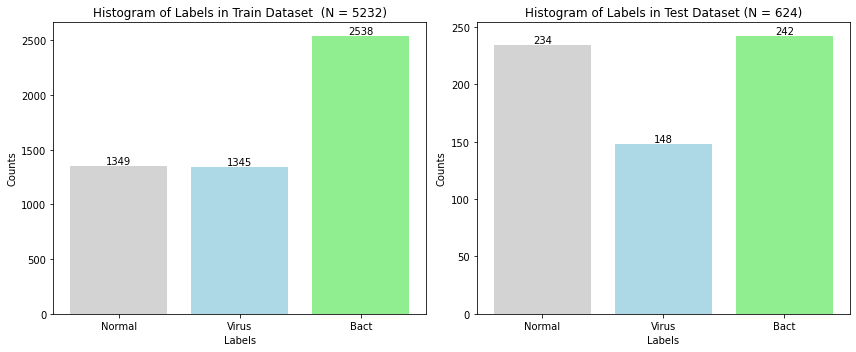

In [8]:
# bar plot of labels in train and dataset
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
train_label_counts = [train_labels.count(0), train_labels.count(1), train_labels.count(2)]
train_label_density = [item/len(train_labels) for item in train_label_counts]
plt.bar(label_names, train_label_counts, color = ['lightgray', 'lightblue', 'lightgreen'])
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title(f"Histogram of Labels in Train Dataset  (N = {len(train_labels)})")

# Add total counts as text annotations
for i, count in enumerate(train_label_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.subplot(1,2,2)
test_label_counts = [test_labels.count(0), test_labels.count(1), test_labels.count(2)]
test_label_density = [item/len(test_labels) for item in test_label_counts]
plt.bar(label_names, test_label_counts, color = ['lightgray', 'lightblue', 'lightgreen'])
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title(f"Histogram of Labels in Test Dataset (N = {len(test_labels)})")

# Add total counts as text annotations
for i, count in enumerate(test_label_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


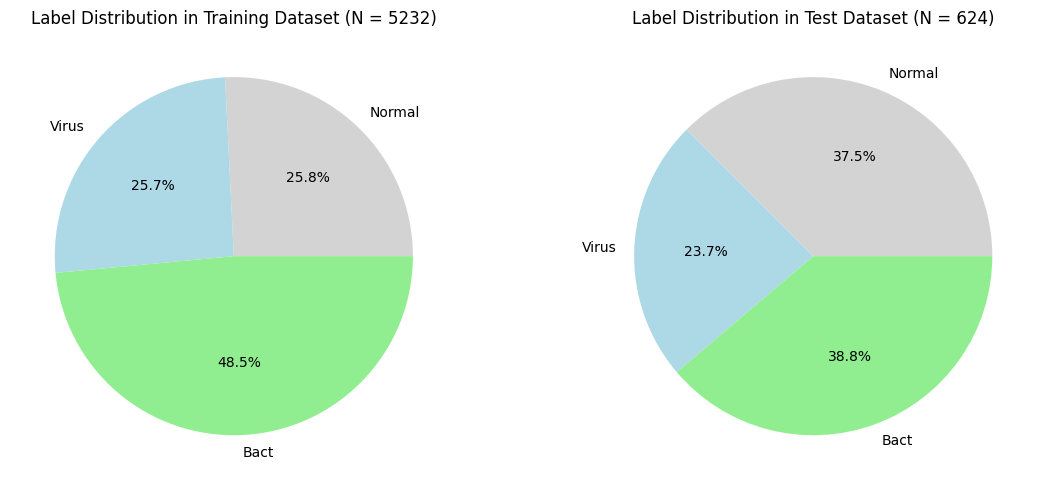

In [9]:
plt.style.use('default')

# Create pie plots for training and test datasets
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pie(train_label_density, labels=label_names, colors=['lightgray', 'lightblue', 'lightgreen'], autopct='%1.1f%%')
plt.title(f"Label Distribution in Training Dataset (N = {len(train_labels)})")

plt.subplot(1, 2, 2)
plt.pie(test_label_density, labels=label_names, colors=['lightgray', 'lightblue', 'lightgreen'], autopct='%1.1f%%')
plt.title(f"Label Distribution in Test Dataset (N = {len(test_labels)})")

plt.tight_layout()
plt.show()


Observing the obtained graphs, the first thing we notice is that in the training set, the total number of pneumonia samples is approximately 75% of the total, also highlighting that viral pneumonia samples constitute half of all available samples. In other words, we have a dataset where the classes are imbalanced. This suggests that the model will likely improve its classification of pneumonia images by having access to more data to learn from, particularly enhancing its ability to identify viral pneumonia. On the other hand, we observe that this sample distribution differs from that of the test set, where the presence of each class is more balanced, despite the lower total of bacterial pneumonia samples.

In [10]:
# load images and resize them to IMG_SIZE*IMG_SIZE
mask_train = ["NORMAL"]*train_labels.count(0) + ["PNEUMONIA"]*(len(train_labels) - train_labels.count(0))
mask_test = ["NORMAL"]*test_labels.count(0) + ["PNEUMONIA"]*(len(test_labels) - test_labels.count(0))

train_images_paths = [os.path.join(train_path,mask_train[i],train_images_paths[i]) for i in range(len(train_images_paths))]
test_images_paths = [os.path.join(test_path,mask_test[i],test_images_paths[i]) for i in range(len(test_images_paths))]

def load_images(images_paths, IMG_SIZE=100):
    '''
    Function to charge the images from the paths and transform them to 1D array
    Arguments:
        images_paths: list
            list of the paths of the images
        IMG_SIZE: int
            size of the images
    Returns:
        images: array
            array of the images with shape (N,IMG_SIZE*IMG_SIZE) and entries between 0 and 255 (grey scale)
    '''
    images = []
    for image_path in images_paths:
        image = cv2.imread(image_path)
        # resize image
        image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
        # transform to grayscale
        image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        images.append(image)
    # reshape images to 1D array
    images = np.array(images).reshape(-1,IMG_SIZE*IMG_SIZE)
    return images

IMG_SIZE = 50 # resize the images to 28x28
train_images = load_images(train_images_paths, IMG_SIZE)
test_images = load_images(test_images_paths, IMG_SIZE)
print(f"Shape of train_images: \t{train_images.shape}")
print(f"Shape of test_images: \t{test_images.shape}")

Shape of train_images: 	(5232, 2500)
Shape of test_images: 	(624, 2500)


Once the images are charged in order to illustrate the data we are working with we will plot different images from the three labels and sets (train/test).

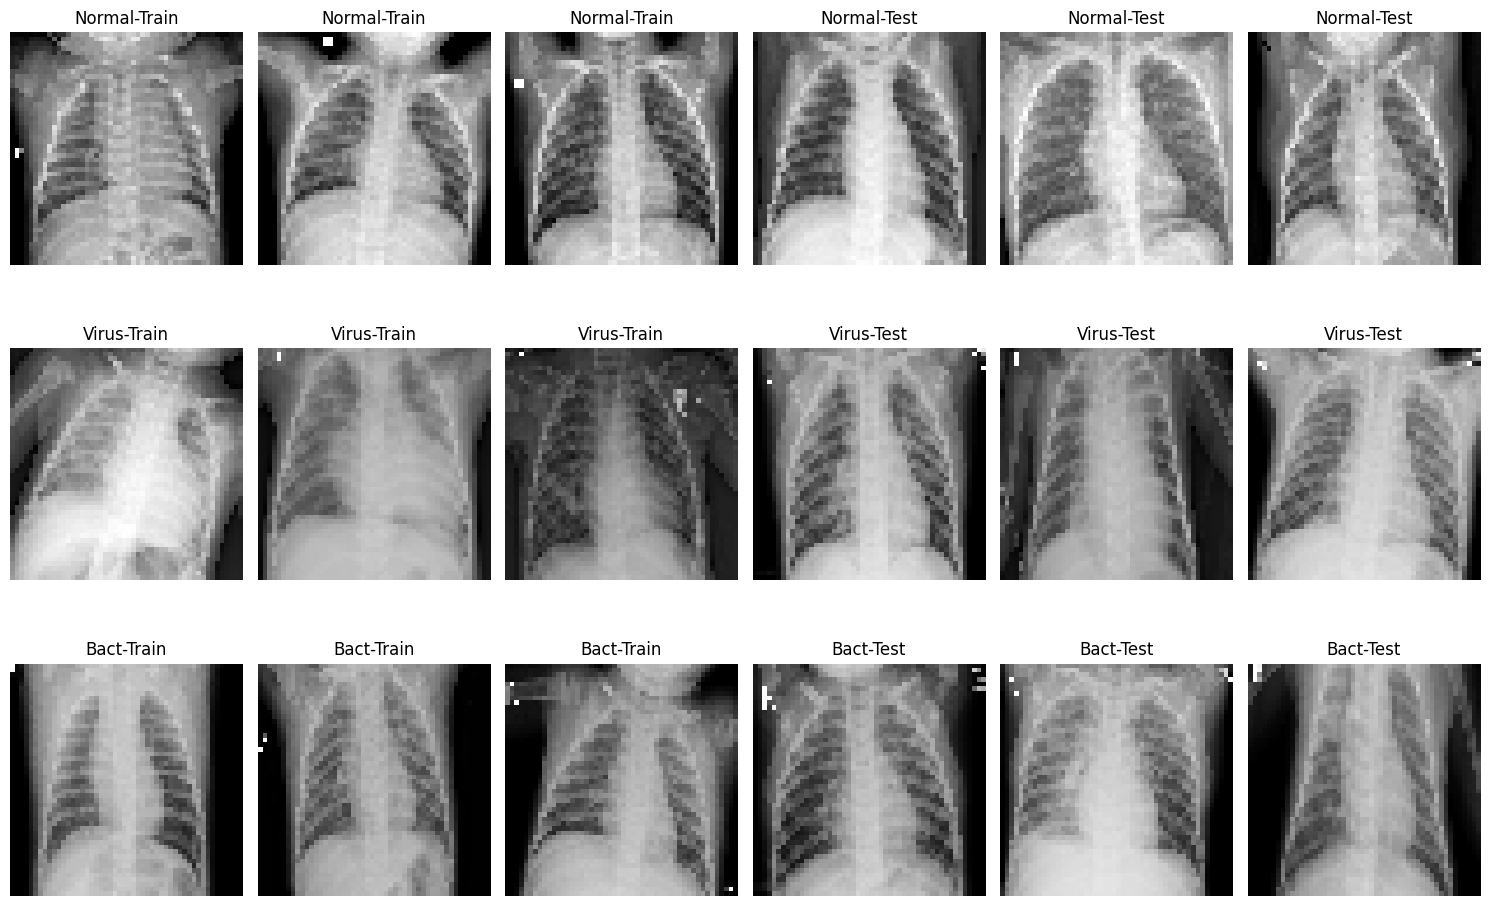

In [11]:
# show three images from each class in training and test dataset
# save 3 images from each class in training and test dataset
normal_train_images = train_images[:3]
virus_train_images = train_images[train_label_counts[0]:train_label_counts[0]+3]
bact_train_images = train_images[train_label_counts[0]+train_label_counts[1]:train_label_counts[0]+train_label_counts[1]+3]
normal_test_images = test_images[:3]
virus_test_images = test_images[test_label_counts[0]:test_label_counts[0]+3]
bact_test_images = test_images[test_label_counts[0]+test_label_counts[1]:test_label_counts[0]+test_label_counts[1]+3]


def show_images(subplot_indexes, images, label, mode = 'Train'):
    '''
    Function to show images in a subplot
    Arguments:
        subplot_indexes: tuple
            tuple of the indexes of the subplot
        images: array
            array of the images to show in the subplot
        label: str
            label of the images (normal, virus or bacteria)
        mode: str
            mode of the images (train or test)
    '''
    i,j_o = subplot_indexes
    for j in range(j_o,j_o+3):
        axes[i,j].imshow(images[j-j_o].reshape(IMG_SIZE,IMG_SIZE),cmap='gray')
        axes[i,j].axis('off')
        axes[i,j].set_title(label+ '-' + mode)


fig,axes = plt.subplots(3,6)
fig.set_size_inches(15,10)

show_images((0,0),normal_train_images,'Normal')
show_images((0,3),normal_test_images,'Normal',mode='Test')
show_images((1,0),virus_train_images,'Virus')
show_images((1,3),virus_test_images,'Virus',mode='Test')
show_images((2,0),bact_train_images,'Bact')
show_images((2,3),bact_test_images,'Bact',mode='Test')

plt.tight_layout()
plt.show()

Now we can analyze the attributes we are working with. Remember we are working with an array of dimension IMG_SIZE*IMG_SIZE per sample and each entry is defined from 0 to 255 in gray scale. 

To deal with this kind of data first we will transform the array into a dataframe and identify explicitly the type of the features and the ratio of missing values (which should be zero taking into account the nature of the data).

Then, we can see in the images that not all pixels are as relevant for the task so we will analyze the correlation between pixels, near pixels should be more correlated than others trying to reduce the number of features. Finally, we will analyze the correlation between the attributes and the target attribute to remove these pixels that have low relevance.

Doing that we will clean the data and reduce the features considerably which will be translated in faster training of models and we will reduce noise of the data.

In [12]:
#Transform the images to dataframes
train_df = pd.DataFrame(train_images)
test_df = pd.DataFrame(test_images)

#Add the labels to the dataframes
train_df['label'] = train_labels
test_df['label'] = test_labels
print("------RAW DATA INFO------")
train_df.info()
test_df.info()

# Verification if there exist missing values   
print(f"\nMissing values in train dataset: {train_df.isna().sum().sum()}")
print(f"Missing values in test dataset: {test_df.isna().sum().sum()}\n")
# Correlation matrix
cm = train_df.corr().abs()

# Set the upper triangle of the correlation matrix to NaN
cm = cm.where(np.triu(np.ones(cm.shape), k=1).astype(bool))

------RAW DATA INFO------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Columns: 2501 entries, 0 to label
dtypes: int64(1), uint8(2500)
memory usage: 12.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Columns: 2501 entries, 0 to label
dtypes: int64(1), uint8(2500)
memory usage: 1.5 MB

Missing values in train dataset: 0
Missing values in test dataset: 0



DATA CLEANING

In [13]:
def data_cleaning(train_df, test_df, corr1, corr2, IMG_SIZE=50):
    print("==================================================")
    print(f"Correlation bound between attributes: {corr1}\nCorrelation bound between attributes and label: {corr2}")
    print("==================================================")
    # Find the indices where correlation is greater than corr1 and less than 1 to drop it
    row_indices, col_indices = np.where((cm > corr1) & (cm < 1))

    # Create a list of tuples with the indices
    tuples = [(row, col) for row, col in zip(row_indices, col_indices)]

    # Remove the attributes [1] of the tuple list from train_df
    train_df_clean = train_df.copy()
    test_df_clean  = test_df.copy()

    dropped_columns = []
    for row, col in tuples:
        if col not in dropped_columns:
            train_df_clean = train_df_clean.drop(col, axis=1)
            test_df_clean  = test_df_clean.drop(col, axis=1)
            dropped_columns.append(col)

    # Verify the updated train_df
    print("-----------CLEAN DATA INFO AFTER DROPPING CORRELATED ATTRIBUTES-----------")
    print(f"Number of tuples where correlation is greater than {corr1} and less than 1: {len(dropped_columns)}")
    print(f"Train set: \t{train_df_clean.shape}")
    print(f"Test test: \t{test_df_clean.shape}")

    # Analyze the relevance of each atributte to the label 
    correlation_with_label = train_df_clean.corrwith(train_df_clean['label']).abs().sort_values(ascending=False)

    train_df_clean = train_df_clean.drop(correlation_with_label[correlation_with_label < corr2].index, axis=1)
    test_df_clean  = test_df_clean.drop(correlation_with_label[correlation_with_label < corr2].index, axis=1)

    # Verify the updated train_df
    print("------CLEAN DATA INFO AFTER DROPPING THE LOWEST INFLUENCE ATTRIBUTES------")
    print(f"Number of dropped columns: {len(correlation_with_label[correlation_with_label < corr2].index)}")
    print(f"Train set: \t{train_df_clean.shape}")
    print(f"Test test: \t{test_df_clean.shape}")

    train_images_clean = train_df_clean.drop('label', axis=1).values
    test_images_clean = test_df_clean.drop('label', axis=1).values

    print(f"Shape of train_data after cleaning: {train_images_clean.shape}")
    print(f"Shape of test_data after cleaning: {test_images_clean.shape}")

    dropped_columns_mask = np.ones((1, IMG_SIZE*IMG_SIZE))
    dropped_columns_mask[:, dropped_columns] = 0

    new_dropped_columns = list(correlation_with_label[correlation_with_label < corr2].index)
    dropped_columns_mask[:, new_dropped_columns] = 0

    return train_images_clean, test_images_clean, dropped_columns_mask

Correlation bound between attributes: 0.95
Correlation bound between attributes and label: 0.05
-----------CLEAN DATA INFO AFTER DROPPING CORRELATED ATTRIBUTES-----------
Number of tuples where correlation is greater than 0.95 and less than 1: 565
Train set: 	(5232, 1936)
Test test: 	(624, 1936)
------CLEAN DATA INFO AFTER DROPPING THE LOWEST INFLUENCE ATTRIBUTES------
Number of dropped columns: 261
Train set: 	(5232, 1675)
Test test: 	(624, 1675)
Shape of train_data after cleaning: (5232, 1674)
Shape of test_data after cleaning: (624, 1674)
Correlation bound between attributes: 0.95
Correlation bound between attributes and label: 0.1
-----------CLEAN DATA INFO AFTER DROPPING CORRELATED ATTRIBUTES-----------
Number of tuples where correlation is greater than 0.95 and less than 1: 565
Train set: 	(5232, 1936)
Test test: 	(624, 1936)
------CLEAN DATA INFO AFTER DROPPING THE LOWEST INFLUENCE ATTRIBUTES------
Number of dropped columns: 559
Train set: 	(5232, 1377)
Test test: 	(624, 1377)
S

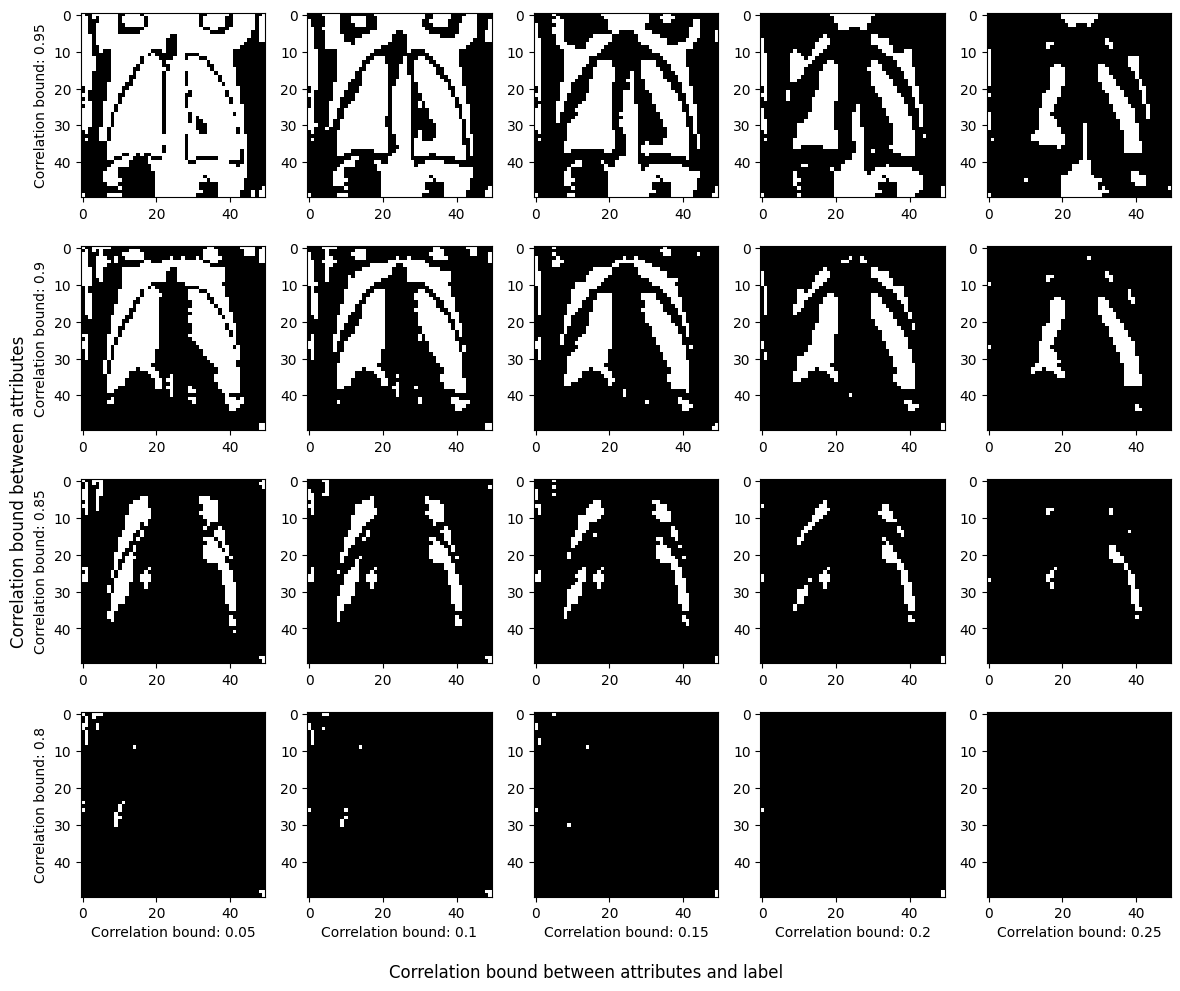

In [14]:
# Find the indices where correlation is greater than 0.9 and less than 1
corr_attributes_bound = [0.95, 0.9, 0.85, 0.8]
corr_label_bound      = [0.05, 0.1, 0.15, 0.2, 0.25]

fig,axes = plt.subplots(4,5)
fig.set_size_inches(12,10)

for i, corr1 in enumerate(corr_attributes_bound):
    for j, corr2 in enumerate(corr_label_bound):
        _, _, dropped_columns_mask = data_cleaning(train_df, test_df, corr1, corr2)
        axes[i,j].imshow(dropped_columns_mask.reshape(IMG_SIZE,IMG_SIZE),cmap='gray')
        
        if i == 3:
            axes[i,j].set_xlabel(f"Correlation bound: {corr2}")
        if j == 0:
            axes[i,j].set_ylabel(f"Correlation bound: {corr1}")

fig.supylabel("Correlation bound between attributes")
fig.supxlabel("Correlation bound between attributes and label")
plt.tight_layout()
plt.show()

In [16]:
# Choose the best combination of correlation bounds
#corr1 = 0.9
#corr2 = 0.15

train_images_clean, test_images_clean, dropped_columns_mask = data_cleaning(train_df, test_df, corr1=0.9, corr2=0.15)

print(train_images_clean.shape)
print(test_images_clean.shape)
print(type(train_images_clean))

Correlation bound between attributes: 0.9
Correlation bound between attributes and label: 0.15


-----------CLEAN DATA INFO AFTER DROPPING CORRELATED ATTRIBUTES-----------
Number of tuples where correlation is greater than 0.9 and less than 1: 1485
Train set: 	(5232, 1016)
Test test: 	(624, 1016)
------CLEAN DATA INFO AFTER DROPPING THE LOWEST INFLUENCE ATTRIBUTES------
Number of dropped columns: 464
Train set: 	(5232, 552)
Test test: 	(624, 552)
Shape of train_data after cleaning: (5232, 551)
Shape of test_data after cleaning: (624, 551)
(5232, 551)
(624, 551)
<class 'numpy.ndarray'>


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5232 samples in 0.008s...


[t-SNE] Computed neighbors for 5232 samples in 2.580s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5232
[t-SNE] Computed conditional probabilities for sample 2000 / 5232
[t-SNE] Computed conditional probabilities for sample 3000 / 5232
[t-SNE] Computed conditional probabilities for sample 4000 / 5232
[t-SNE] Computed conditional probabilities for sample 5000 / 5232
[t-SNE] Computed conditional probabilities for sample 5232 / 5232
[t-SNE] Mean sigma: 276.536896
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.085419
[t-SNE] KL divergence after 300 iterations: 2.492321


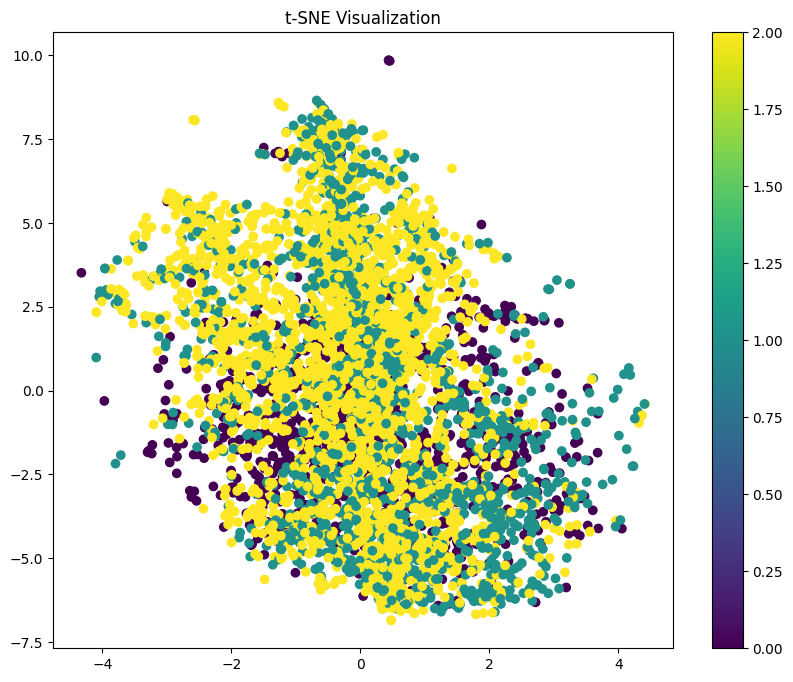

In [111]:
# Create a t-SNE object
tsne = TSNE(n_components=3, random_state=42, verbose=1, perplexity=40, n_iter=300, init='random', learning_rate=200)

# Fit and transform the data
X_tsne = tsne.fit_transform(train_images)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_labels, cmap='viridis')
plt.colorbar()

plt.title('t-SNE Visualization')
plt.show()

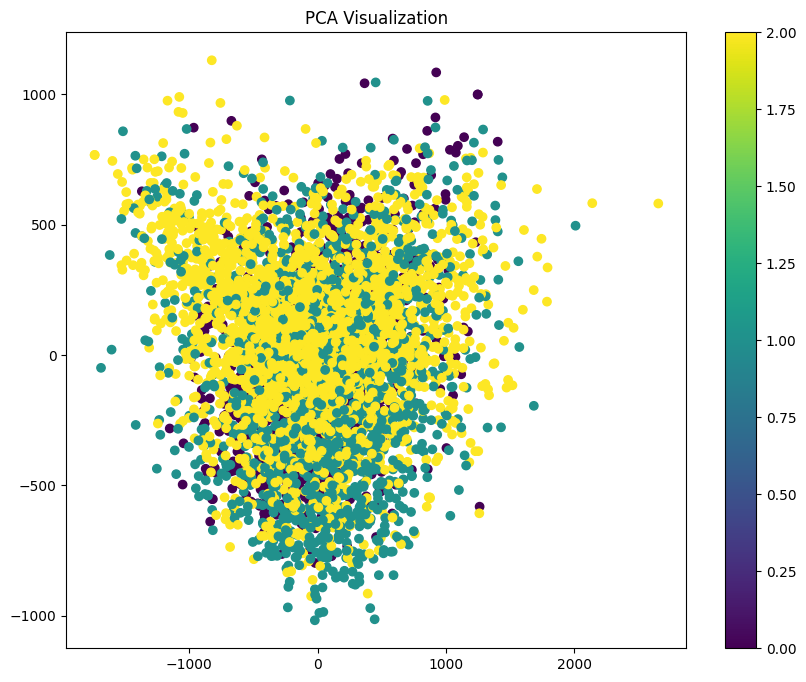

In [108]:
# visualize data using PCA

# Create a PCA instance
pca = PCA(n_components=100)
# Fit the PCA instance to the scaled samples
pca.fit(train_images)
# Transform the scaled samples: pca_features
pca_features = pca.transform(train_images)
# Plot the points using the classes as colors
plt.figure(figsize=(10, 8))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=train_labels, cmap='viridis')
plt.colorbar()
plt.title('PCA Visualization')
plt.show()

#### Binary Classification: Normal vs Pneumonia

#### 1- Baseline model

In [15]:
# Baseline Model implementation
class BaselineModel:
    def __init__(self, labels):
        self.labels = labels
        self.means = np.zeros((len(labels), IMG_SIZE*IMG_SIZE))
        pass

    def fit(self, X, y):
        # calculate the "mean image" of each class
        for i in range(len(self.labels)):
            self.means[i] = np.mean(X[y == i, :], axis=0)
        pass

    def predict(self, X):
        # calculate the distance between each sample and each class mean and assign the 
        # class with the smallest norm2 distance
        y_pred = np.zeros(len(X))
        for i in range(len(X)):
            norms = np.linalg.norm(self.means - X[i], axis=1)
            y_pred[i] = np.argmin(norms)
        return y_pred

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [16]:
# train the baseline model
baseline = BaselineModel(labels=[0, 1])
train_labels = np.where(np.array(train_labels) == 0, 0, 1)
test_labels = np.where(np.array(test_labels) == 0, 0, 1)
baseline.fit(train_images, train_labels)
baseline.means.shape

(2, 784)

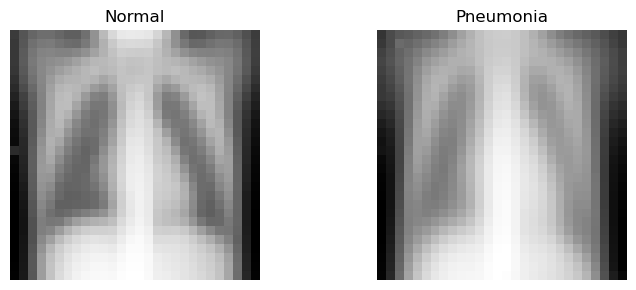

In [17]:
# visualize the mean images of each class
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
axes[0].imshow(baseline.means[0].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Normal')
axes[1].imshow(baseline.means[1].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
axes[1].axis('off')
axes[1].set_title('Pneumonia')
plt.tight_layout()
plt.show()

In [18]:
# evaluate the baseline model on the train dataset
print(classification_report(train_labels, baseline.predict(train_images), target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.69      0.87      0.77      1349
   Pneumonia       0.95      0.87      0.91      3883

    accuracy                           0.87      5232
   macro avg       0.82      0.87      0.84      5232
weighted avg       0.88      0.87      0.87      5232



In [19]:
# evaluate the baseline model on the test dataset
print(classification_report(test_labels, baseline.predict(test_images), target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.75      0.77      0.76       234
   Pneumonia       0.86      0.85      0.85       390

    accuracy                           0.82       624
   macro avg       0.80      0.81      0.81       624
weighted avg       0.82      0.82      0.82       624



#### 2- Logistic regression classifier

In [20]:
# apply PCA to the train and test datasets to reduce dimensionality
pca = PCA(n_components=IMG_SIZE)

pca.fit(train_images)
train_images_pca = pca.transform(train_images)
test_images_pca = pca.transform(test_images)
train_images_pca.shape, test_images_pca.shape

((5232, 28), (624, 28))

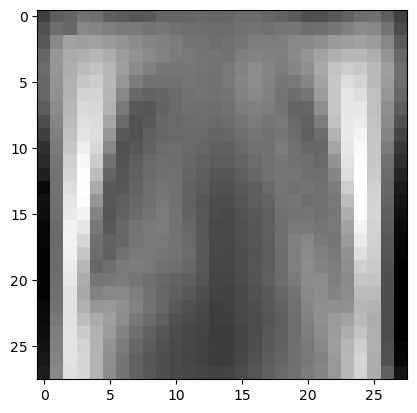

In [21]:
# visualize pca matrix
transformationMatrix = pca.components_.transpose()
plt.imshow(transformationMatrix[:,0].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
plt.show()

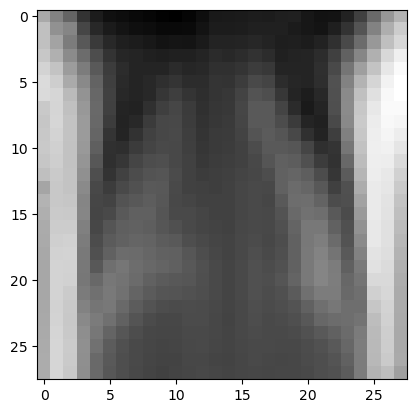

In [22]:
plt.imshow(transformationMatrix[:,1].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
plt.show()

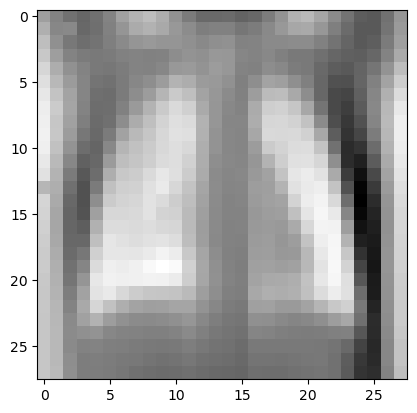

In [23]:
plt.imshow(transformationMatrix[:,2].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
plt.show()

In [24]:
# Logistic regression classifier
logreg = LogisticRegression(class_weight="balanced", max_iter=1000)
logreg.fit(train_images_pca, train_labels)
print("Train accuracy:", logreg.score(train_images_pca, train_labels))
print("Test accuracy:", logreg.score(test_images_pca, test_labels))

Train accuracy: 0.9415137614678899
Test accuracy: 0.7836538461538461


In [25]:
# evaluate the logistic regression classifier on the test dataset
print(classification_report(test_labels, logreg.predict(test_images_pca), target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.87      0.50      0.63       234
   Pneumonia       0.76      0.95      0.85       390

    accuracy                           0.78       624
   macro avg       0.81      0.73      0.74       624
weighted avg       0.80      0.78      0.77       624



In [26]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=27, max_depth=6, random_state=42, class_weight="balanced")
rf.fit(train_images_pca, train_labels)
print("Train accuracy:", rf.score(train_images_pca, train_labels))
print("Test accuracy:", rf.score(test_images_pca, test_labels))

Train accuracy: 0.9510703363914373
Test accuracy: 0.7852564102564102


In [27]:
# evaluate the random forest classifier on the test dataset
print(classification_report(test_labels, rf.predict(test_images_pca), target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.83      0.54      0.65       234
   Pneumonia       0.77      0.93      0.84       390

    accuracy                           0.79       624
   macro avg       0.80      0.74      0.75       624
weighted avg       0.79      0.79      0.77       624



In [45]:
# SVM Classifier
# Para el fine tuning de los hiperparametros tener en cuenta el numero de iteraciones
# el class_weight, el ganma y el kernel. También el preprocesamiento de los datos con 
# StandardScaler o MinMaxScaler
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
train_images_scaled = std_scaler.fit_transform(train_images_pca)
test_images_scaled = std_scaler.transform(test_images_pca)
svm = SVC(kernel='linear', gamma=0.01, class_weight="balanced", max_iter=100000)
svm.fit(train_images_scaled, train_labels)
print("Train accuracy:", svm.score(train_images_scaled, train_labels))
print("Test accuracy:", svm.score(test_images_scaled, test_labels))

Train accuracy: 0.9428516819571865
Test accuracy: 0.7868589743589743


/Users/javierlopetegui/Documents/School/TESIS/Thesis/thesis/Implementation/Thesis/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [47]:
# evaluate the SVM classifier on the test dataset
print(classification_report(test_labels, svm.predict(test_images_scaled), target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.87      0.50      0.64       234
   Pneumonia       0.76      0.96      0.85       390

    accuracy                           0.79       624
   macro avg       0.82      0.73      0.74       624
weighted avg       0.80      0.79      0.77       624



In [58]:
svm = SVC(kernel='rbf', gamma=0.001, class_weight="balanced", max_iter=10000)
svm.fit(train_images_scaled, train_labels)
print("Train accuracy:", svm.score(train_images_scaled, train_labels))
print("Test accuracy:", svm.score(test_images_scaled, test_labels))

Train accuracy: 0.9405581039755352
Test accuracy: 0.7788461538461539


In [64]:
svm = SVC(kernel='poly', gamma=0.01, class_weight="balanced", max_iter=10000)
svm.fit(train_images_scaled, train_labels)
print("Train accuracy:", svm.score(train_images_scaled, train_labels))
print("Test accuracy:", svm.score(test_images_scaled, test_labels))

Train accuracy: 0.8992737003058104
Test accuracy: 0.7147435897435898


In [68]:
svm = SVC(kernel='sigmoid', gamma=0.01, class_weight="balanced", max_iter=10000)
svm.fit(train_images_scaled, train_labels)
print("Train accuracy:", svm.score(train_images_scaled, train_labels))
print("Test accuracy:", svm.score(test_images_scaled, test_labels))

Train accuracy: 0.9353975535168195
Test accuracy: 0.782051282051282
